<a href="https://colab.research.google.com/github/namanwahi/notebooks/blob/main/tfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
% pip install shap
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import shap
import numpy as np
from sklearn.datasets import make_regression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
N_BINS = 7
INPUT_SIZE = 15

In [3]:
X, y_c = make_regression(
    n_samples=100000,
    n_features=INPUT_SIZE,
    n_informative=6,
    bias=123.43,
)


discretizer = KBinsDiscretizer(
    n_bins=N_BINS,
    encode="onehot-dense",
    strategy="quantile",
)
y = discretizer.fit_transform(y_c.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5)

X_train = X_train.astype("float32")
y_train = y_train.astype("float32")
X_test = X_test.astype("float32")
y_test = y_test.astype("float32")
bin_edges = discretizer.bin_edges_[0].astype("float32")

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Bin edges ", bin_edges)

(99995, 15)
(99995, 7)
(5, 15)
(5, 7)
Bin edges  [-588.66188933  -51.23545982   30.76986534   93.92907141  154.22114523
  217.80052826  300.55179401  822.02335967]


In [4]:
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(INPUT_SIZE,)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(N_BINS, activation="softmax"),
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 217       
Total params: 697
Trainable params: 697
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.fit(
    x=X_train,
    y=y_train,
    epochs=1,
    batch_size=512,
)

196/196 [==============================] - 0s 1ms/step - loss: 2.1062


In [6]:
predictions = model.predict(X_test)
print(predictions.shape)

(5, 7)


In [7]:
print("Probability density", predictions[0].tolist())

Probability density [0.0736200362443924, 0.14444173872470856, 0.13637690246105194, 0.2327083945274353, 0.21384119987487793, 0.09487288445234299, 0.1041388213634491]


In [8]:
quantized_dist = tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical(probs=predictions[0]),
    components_distribution=tfp.distributions.Uniform(low=discretizer.bin_edges_[0][:-1].astype("float32"), high=discretizer.bin_edges_[0][1:].astype("float32"))
)

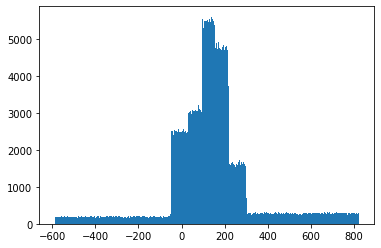

In [9]:
samples = quantized_dist.sample(sample_shape=(1000000,))
plt.hist(samples, bins=1000)
plt.show()

In [11]:
quantized_dist.cdf(0.0)
quantized_dist.quantile(0.5)

NotImplementedError: ignored

In [ ]:
def sampled_median(bin_edges, probabilities):
  quantized_dist = tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical(probs=predictions[0]),
    components_distribution=tfp.distributions.Uniform(low=discretizer.bin_edges_[0][:-1].astype("float32"), high=discretizer.bin_edges_[0][1:].astype("float32"))
  )

def analytic_median():
